# MSE model with attenuation correction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LinearRegression
from utils import load_data, RegressionModel, train_model, plot_results

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

For this analysis, we use the "small dataset" with 10k samples selected at random from the full 60K DHS dataset. The data we use consists of latent representations of satllite images $X \in \mathbb{R}^{232}$ and corresponding International Wealth Index (IWI) values $y \in \mathbb{R}$ from survey data. For now, we use the same train-test splits for all experiments, but we should evaluate with cross-validation.

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = load_data()

Unless otherwised specified, we use the same basic regression model.

In [4]:
RegressionModel()

RegressionModel(
  (fc): Sequential(
    (0): Linear(in_features=232, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

# Model training

The helper function `train_model`, that creates and trains a `RegressionModel` using gradient descent, has the main arguments `X_train, X_val, y_train, y_val, loss_fn`. `loss_fn` is supposed to be a function that in addition to returning the loss to minimize should return a dict object with whatever metric you would like to log during training.

## MSE baseline

  0%|          | 0/50000 [00:00<?, ?it/s]

  5%|▍         | 2251/50000 [00:05<01:50, 432.47it/s]


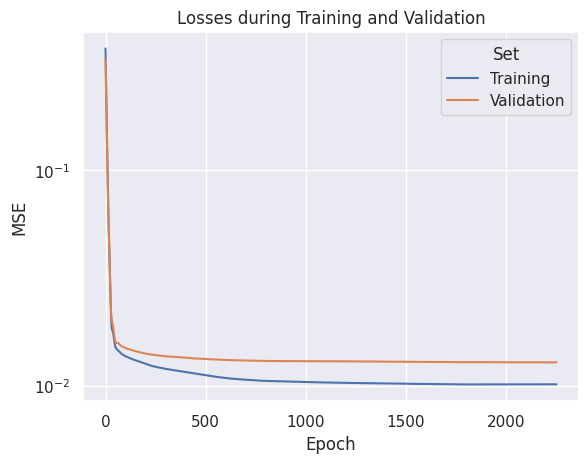

In [5]:
# Example of a loss function that only tracks one metric (MSE)
def mse_loss(pred, target):
    mse = nn.MSELoss()(pred, target)
    return mse, {'MSE': mse.item()}

mse_model = train_model(X_train, X_val, y_train, y_val, lr=1e-3, l2=1e-2, loss_fn=mse_loss, verbose=1)

When we plot the results, we see that the model suffers from attenuation error (the model overestimates wealth for poor places and underestimates for wealthy places).

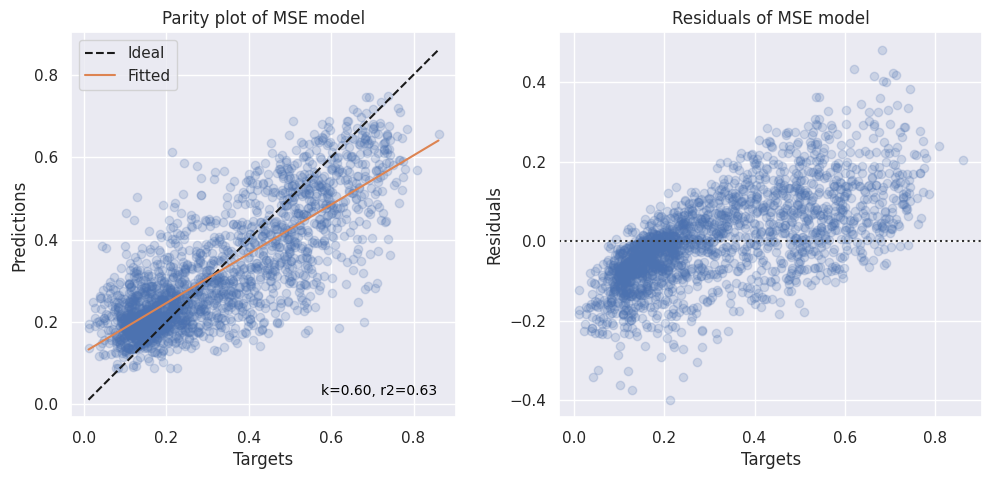

In [6]:
with torch.no_grad():
    y_pred = mse_model(X_test)
    
plot_results(y_test, y_pred, 'MSE model')

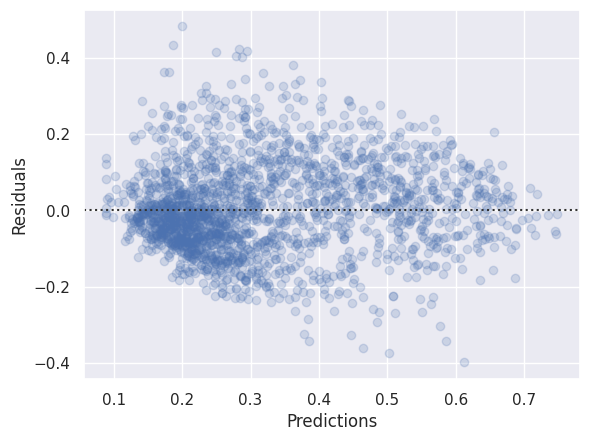

In [8]:
import matplotlib.pyplot as plt

targets = y_test.cpu().numpy()
predictions = y_pred.cpu().numpy()

# Create a new figure and axis if none is provided
fig, ax = plt.subplots()

ax.scatter(predictions, (targets - predictions), alpha=0.2)
ax.axhline(0, ls=":", c=".2")
ax.set_xlabel('Predictions')
ax.set_ylabel('Residuals')

plt.show()

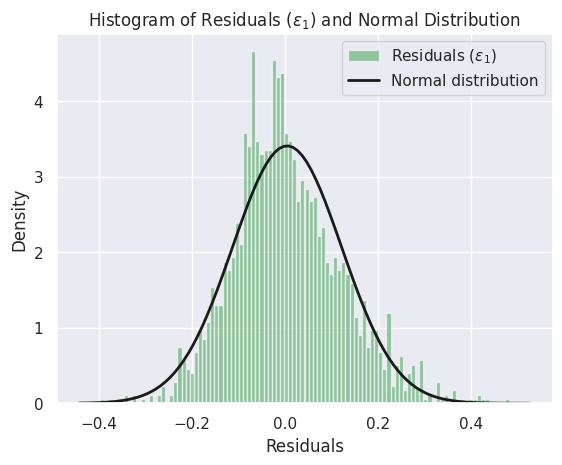

In [11]:
e_1 = (targets - predictions)

from scipy.stats import norm, kstest
import numpy as np

# Plot histogram of e_1
plt.hist(e_1, bins=100, density=True, alpha=0.6, color='g', label=r'Residuals ($\epsilon_1$)')

# Plot normal distribution for comparison
mu, std = norm.fit(e_1)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal distribution')

# Add legend and titles
plt.legend(loc='upper right')
plt.title(r'Histogram of Residuals ($\epsilon_1$) and Normal Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')

plt.show()

One idea is to simply correct for this by fitting a linear regression on the calibration data (should be a separate hold-out set later) and using the coefficients to "correct" the predictions

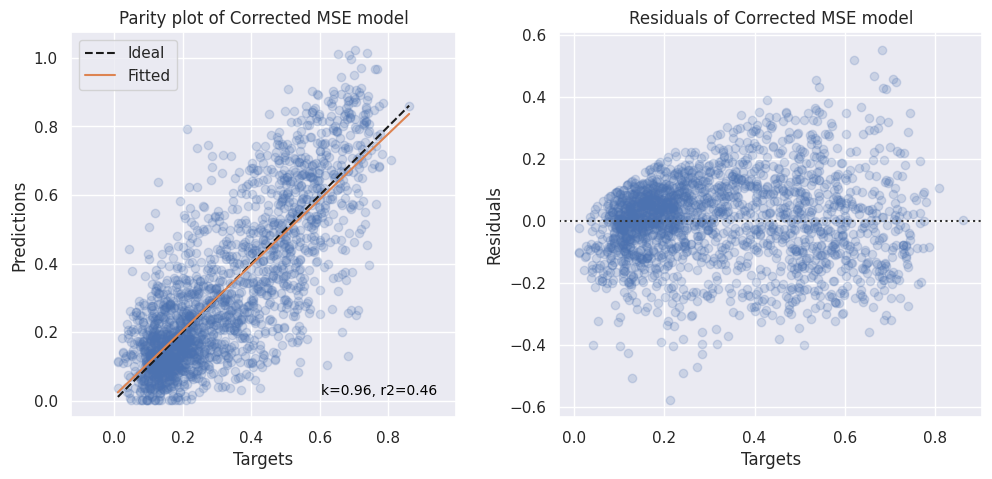

In [7]:
with torch.no_grad():
    y_pred_val = mse_model(X_val)
    slope_model = LinearRegression().fit(y_val.cpu().numpy().reshape(-1, 1), y_pred_val.cpu().numpy())
    
corrected_y_pred = (y_pred - slope_model.intercept_) / slope_model.coef_[0]

plot_results(y_test, corrected_y_pred, 'Corrected MSE model')

The correction causes $r^2$ to take a hit, but now the ATE estimate should be unbiased. That is, if you belive the relationship between $y$ and $\hat{y}$ to be linear.